In [ ]:
# Import libraries
import contextily as cx
from datetime import datetime
import geopandas
import geodatasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
# Download the 311 complaints about syringes
syringe_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?descriptor=Syringes&$limit=50000')
syringe_complaints.head(2)

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,64443980,2025-03-23T09:10:30.000,NaN,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,10018.0,434 WEST 38 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.756596,-73.996127,"\n, \n(40.75659591114857, -73.99612698908115)"
1,64438854,2025-03-23T08:20:21.000,NaN,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,10463.0,WEST 239 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Look at the data types
syringe_complaints.dtypes

,0
unique_key,int64
created_date,object
closed_date,object
agency,object
agency_name,object
complaint_type,object
descriptor,object
location_type,object
incident_zip,float64
incident_address,object


In [ ]:
# Convert created_date from an object to a date
syringe_complaints['created_date'] = pd.to_datetime(syringe_complaints['created_date'])

In [ ]:
# Extract month and year from created_date
syringe_complaints['month'] = syringe_complaints['created_date'].dt.month
syringe_complaints['year'] = syringe_complaints['created_date'].dt.year

In [ ]:
# Look for missing values
syringe_complaints.isna().sum()

,0
unique_key,0
created_date,0
closed_date,18
agency,0
agency_name,0
complaint_type,0
descriptor,0
location_type,0
incident_zip,1
incident_address,1


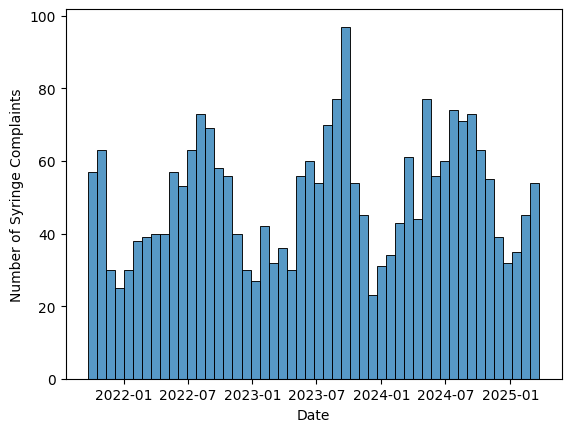

In [ ]:
# Make a plot to show the frequency of syringe complaints
ax = sns.histplot(data=syringe_complaints['created_date'], bins = 50)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Syringe Complaints')
plt.show()

Interesting finding: syringe complaints appear to peak at similar times each year!

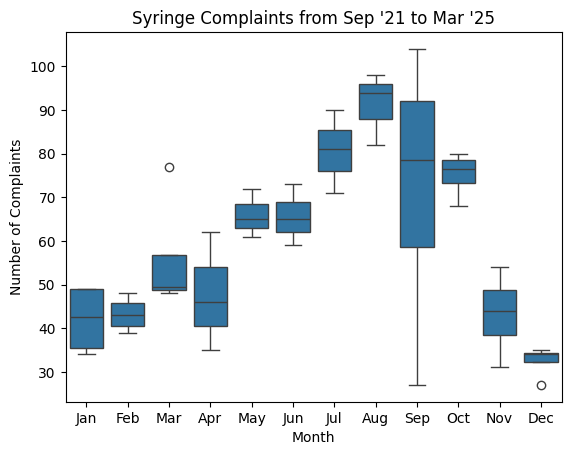

In [ ]:
# Make a boxplot to show the number of syringe complaints each month
ax = sns.boxplot(data = syringe_complaints.groupby(['year', 'month'])['created_date'].agg(complaint_count = 'count').reset_index(),
                 x = 'month',
                 y = 'complaint_count')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Complaints')
plt.title('Syringe Complaints from Sep \'21 to Mar \'25')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

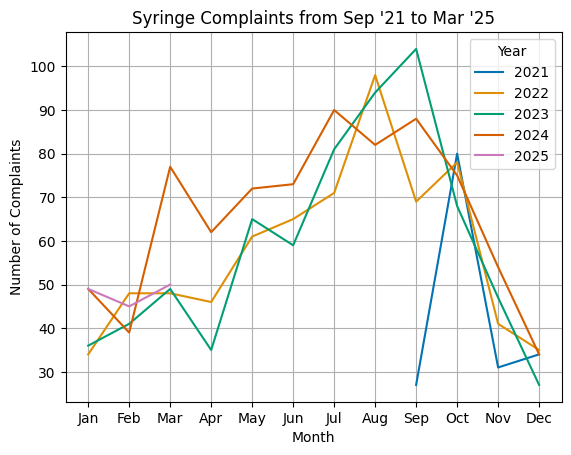

In [ ]:
# Make a lineplot of the number of syringe complaints each month, with a different line pear year
ax = sns.lineplot(data = syringe_complaints.groupby(['year', 'month'])['created_date'].agg(complaint_count = 'count').reset_index(),
                  x = 'month',
                  y = 'complaint_count',
                  hue = 'year',
                  palette = 'colorblind')
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.title('Syringe Complaints from Sep \'21 to Mar \'25')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.show()

Much more analysis TBD...

In [ ]:
# Download the sharps dropoff site data
dropoff_sites = pd.read_csv('https://data.cityofnewyork.us/resource/edk2-vkjh.csv')
dropoff_sites.head(2)

,borough,ntaname,site_type,sitename,zipcode,phonenum,days_hours,address,borocd,notes,...,councildist,senate_district,_congress_district,assembly_district,police_precints,bbl,bin,latitude,longitude,point
0,Bronx,Norwood,SYRINGE/SHARPS Drop-off,North Central Bronx Hospital,10467,718-918-5000,24/7,"3424 Kossuth Ave, Bronx, NY 10467",207,Lobby,...,11,33,15,81,52,2.033270e+09,2017787.0,40.880432,-73.881204,POINT (-73.881205418129 40.8804402931774)
1,Queens,Flushing-Willets Point,SYRINGE/SHARPS Drop-off,Union Plaza Care Center,11354,718-670-0765,10am-2pm,"33-23 Union St. Flushing, NY 11354",407,Lobby,...,20,16,6,40,109,4.049810e+09,4112550.0,40.767323,-73.826924,POINT (-73.8269253950036 40.7673312732314)


# Maps

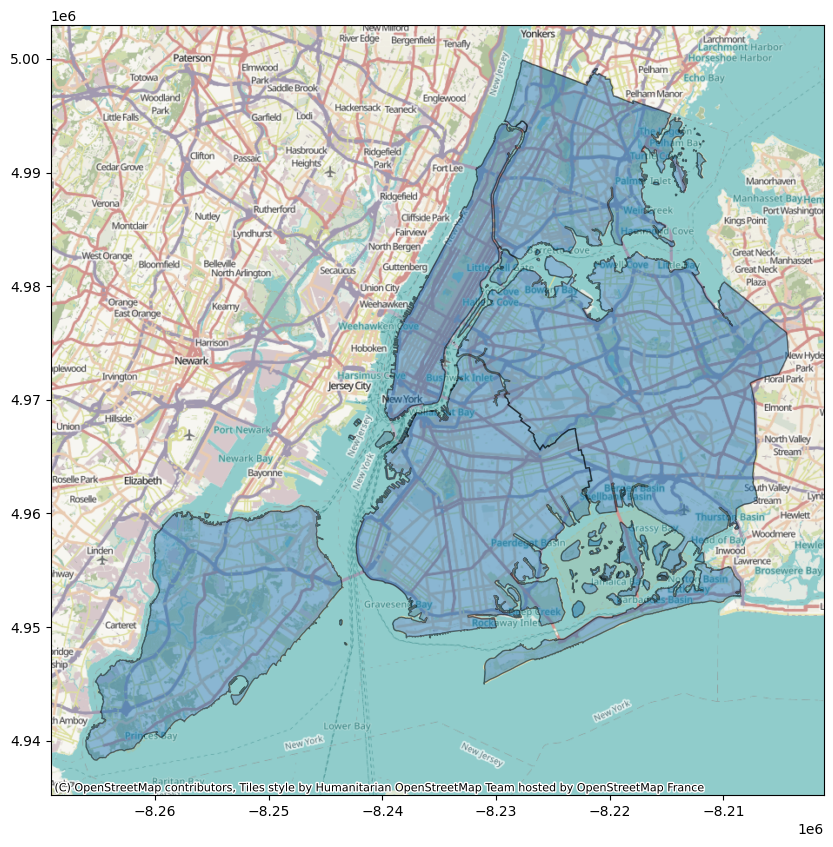

In [ ]:
# Testing how to make maps
nyc = geopandas.read_file(geodatasets.get_path("nybb")).to_crs(epsg=3857)
ax = nyc.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
cx.add_basemap(ax)

In [ ]:
# List the columns in the dropoff_sites dataframe
dropoff_sites.head(1)

,borough,ntaname,site_type,sitename,zipcode,phonenum,days_hours,address,borocd,notes,...,councildist,senate_district,_congress_district,assembly_district,police_precints,bbl,bin,latitude,longitude,point
0,Bronx,Norwood,SYRINGE/SHARPS Drop-off,North Central Bronx Hospital,10467,718-918-5000,24/7,"3424 Kossuth Ave, Bronx, NY 10467",207,Lobby,...,11,33,15,81,52,2.033270e+09,2017787.0,40.880432,-73.881204,POINT (-73.881205418129 40.8804402931774)


This dataframe already contains the column 'point' which is the right format.

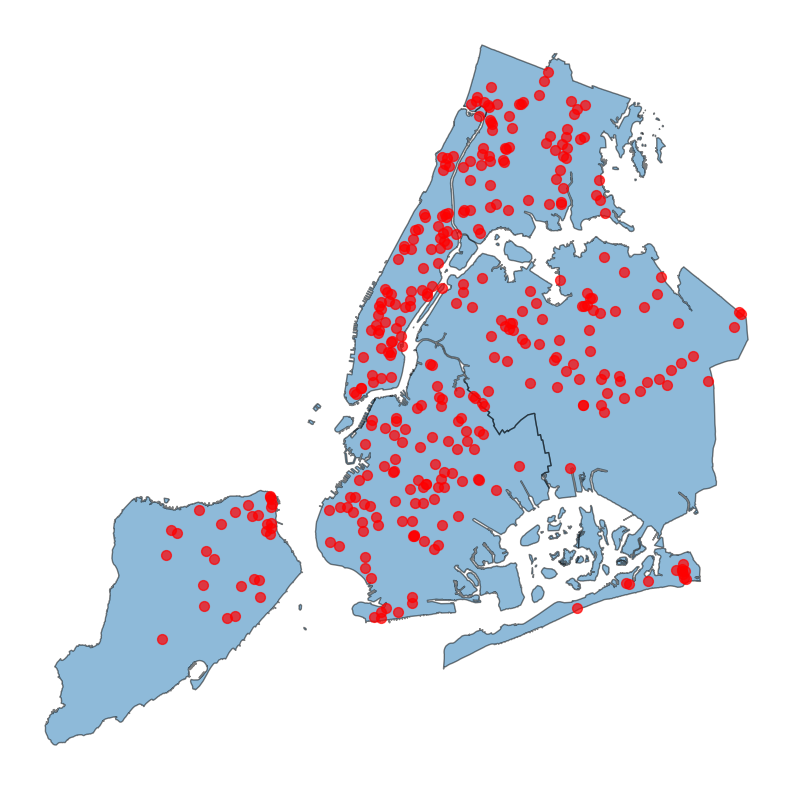

In [ ]:
# Load NYC map
nyc = geopandas.read_file(geodatasets.get_path("nybb")).to_crs(epsg=3857)

# Convert dataframe to a GeoDataFrame
gdf_points = geopandas.GeoDataFrame(dropoff_sites, geometry=geopandas.points_from_xy(dropoff_sites.longitude, dropoff_sites.latitude), crs="EPSG:4326")

# Reproject points to match the NYC map CRS
gdf_points = gdf_points.to_crs(epsg=3857)

# Plot the NYC map
ax = nyc.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")

# Plot the points on top
gdf_points.plot(ax=ax, color='red', markersize=50, alpha=0.7)

# Add a basemap
#cx.add_basemap(ax)

# Show the plot
ax.set_axis_off()

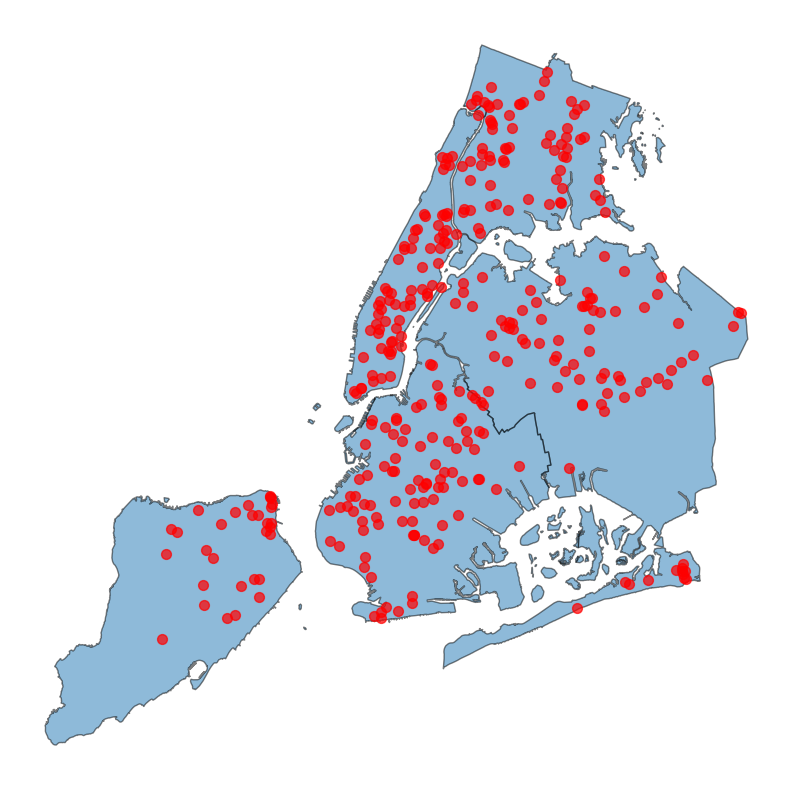

In [ ]:
# Load NYC map
nyc = geopandas.read_file(geodatasets.get_path("nybb")).to_crs(epsg=4326)

# Convert dataframe to a GeoDataFrame
gdf_points = geopandas.GeoDataFrame(dropoff_sites, geometry=geopandas.points_from_xy(dropoff_sites.longitude, dropoff_sites.latitude), crs="EPSG:4326")

# Reproject points to match the NYC map CRS
#gdf_points = gdf_points.to_crs(epsg=3857)

# Plot the NYC map
ax = nyc.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")

# Plot the points on top
gdf_points.plot(ax=ax, color='red', markersize=50, alpha=0.7)

# Add a basemap
#cx.add_basemap(ax)

# Show the plot
ax.set_axis_off()

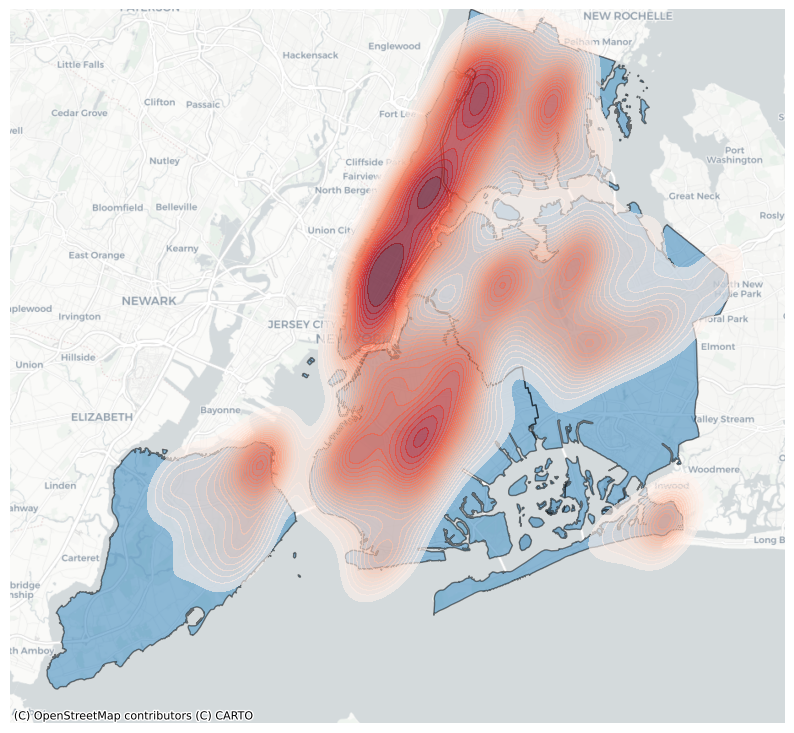

In [ ]:
# Load NYC map
nyc = geopandas.read_file(geodatasets.get_path("nybb")).to_crs(epsg=3857)

# Convert to GeoDataFrame and transform to EPSG:3857
syringe_complaints_points = geopandas.GeoDataFrame(syringe_complaints,
                                                   geometry=geopandas.points_from_xy(syringe_complaints.longitude, syringe_complaints.latitude), crs="EPSG:4326")
syringe_complaints_points  = gdf_points.to_crs(epsg=3857)

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))
nyc.plot(ax=ax, alpha=0.5, edgecolor="k")  # Plot NYC map

# Extract x, y coordinates
x = syringe_complaints_points.geometry.x
y = syringe_complaints_points.geometry.y

# Plot heatmap with seaborn
sns.kdeplot(
    x=x, y=y, ax=ax,
    cmap="Reds",  # Change color
    fill=True,
    alpha=0.6,  # Adjust transparency
    levels=30,  # Number of contour levels
    bw_adjust=0.5,  # Adjust bandwidth (smaller = sharper, larger = smoother)
    clip=nyc.total_bounds.reshape(2, 2)  # Clip to NYC boundaries
)


# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Remove axes
ax.set_axis_off()

plt.show()